In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/螺纹盘面成本.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['螺纹盘面成本'].last_valid_index()   

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,焦炭期货价格,铁矿期货价格,螺纹盘面成本
2025-11-17,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/焦炭/eta/焦炭期货价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/焦炭/eta/焦炭期货价格_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['焦炭期货价格'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()   

,Date,焦炭期货价格_预测
19,2025-10-27,1794.108853
18,2025-10-28,1780.101903
17,2025-10-29,1768.094954
16,2025-10-30,1759.688004
15,2025-10-31,1769.081055


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/黑色/铁矿/eta/铁矿期货价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/黑色/铁矿/eta/铁矿期货价格_合并数据.xlsx")
]

file_path2 = None
for path2 in file_paths2:
    if os.path.isfile(path2):  # 确保是文件而不是目录
        file_path2 = path2
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['铁矿期货价格'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()   

,Date,铁矿期货价格_预测
22,2025-10-25,771.0000
21,2025-10-27,770.8251
20,2025-10-28,780.3351
19,2025-10-29,799.2262
18,2025-10-30,802.1327


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '焦炭期货价格_预测']],
    on='Date',
    how='left'
)
sheet_daily['焦炭期货价格'] = sheet_daily['焦炭期货价格'].fillna(sheet_daily['焦炭期货价格_预测'])
sheet_daily = sheet_daily.drop(columns=['焦炭期货价格_预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '铁矿期货价格_预测']],
    on='Date',
    how='left'
)
sheet_daily['铁矿期货价格'] = sheet_daily['铁矿期货价格'].fillna(sheet_daily['铁矿期货价格_预测'])
sheet_daily = sheet_daily.drop(columns=['铁矿期货价格_预测'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,焦炭期货价格,铁矿期货价格,螺纹盘面成本
3540,2025-11-10,1735.014943,817.1155,NaN
3541,2025-11-11,1717.285535,823.7217,NaN
3542,2025-11-12,1698.856128,817.1910,NaN
3543,2025-11-13,1679.126719,803.9126,NaN
3544,2025-11-14,1664.097312,805.2450,NaN
3545,2025-11-17,1660.608828,817.6435,NaN
3546,2025-11-18,1656.720345,809.8199,NaN
3547,2025-11-19,1656.131862,808.2915,NaN
3548,2025-11-20,1651.643378,807.2042,NaN
3549,2025-11-21,1654.154896,809.9102,NaN


In [8]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['螺纹盘面成本_预测'] = 1.7*sheet_daily['铁矿期货价格']+0.5*sheet_daily['焦炭期货价格']+1200
sheet_daily.tail()

,Date,焦炭期货价格,铁矿期货价格,螺纹盘面成本,螺纹盘面成本_预测
3545,2025-11-17,1660.608828,817.6435,NaN,3420.298364
3546,2025-11-18,1656.720345,809.8199,NaN,3405.054003
3547,2025-11-19,1656.131862,808.2915,NaN,3402.161481
3548,2025-11-20,1651.643378,807.2042,NaN,3398.068829
3549,2025-11-21,1654.154896,809.9102,NaN,3403.924788


In [9]:
last_day = sheet_daily['Date'][sheet_daily['螺纹盘面成本'].last_valid_index()]

---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '螺纹盘面成本']]
historical.columns = ['Date', '螺纹盘面成本']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '螺纹盘面成本_预测']]
forecast.columns = ['Date', '螺纹盘面成本_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/螺纹盘面成本_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily.head()

,Date,螺纹盘面成本,螺纹盘面成本_预测
600,2025/11/21,NaN,3403.924788
599,2025/11/20,NaN,3398.068829
598,2025/11/19,NaN,3402.161481
597,2025/11/18,NaN,3405.054003
596,2025/11/17,NaN,3420.298364


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '螺纹盘面成本']]
historical_monthly.columns = ['Date', '螺纹盘面成本']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '螺纹盘面成本_预测']]
forecast_monthly.columns = ['Date', '螺纹盘面成本_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/螺纹盘面成本_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,螺纹盘面成本,螺纹盘面成本_预测
29,2025/11/30,NaN,3426.812840
28,2025/10/31,3367.504167,3386.831945
27,2025/09/30,3382.031818,3382.031818
26,2025/08/31,3373.304762,3373.304762
25,2025/07/31,3283.508696,3283.508696


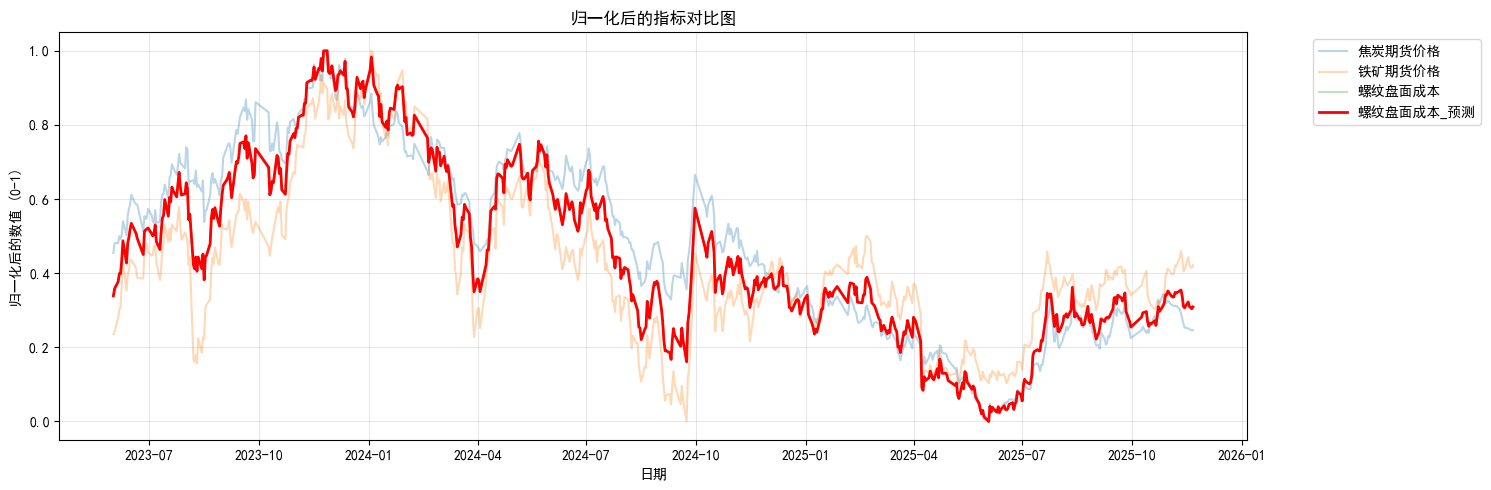

In [12]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()

# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(sheet_daily[columns_to_normalize])


# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == '螺纹盘面成本_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



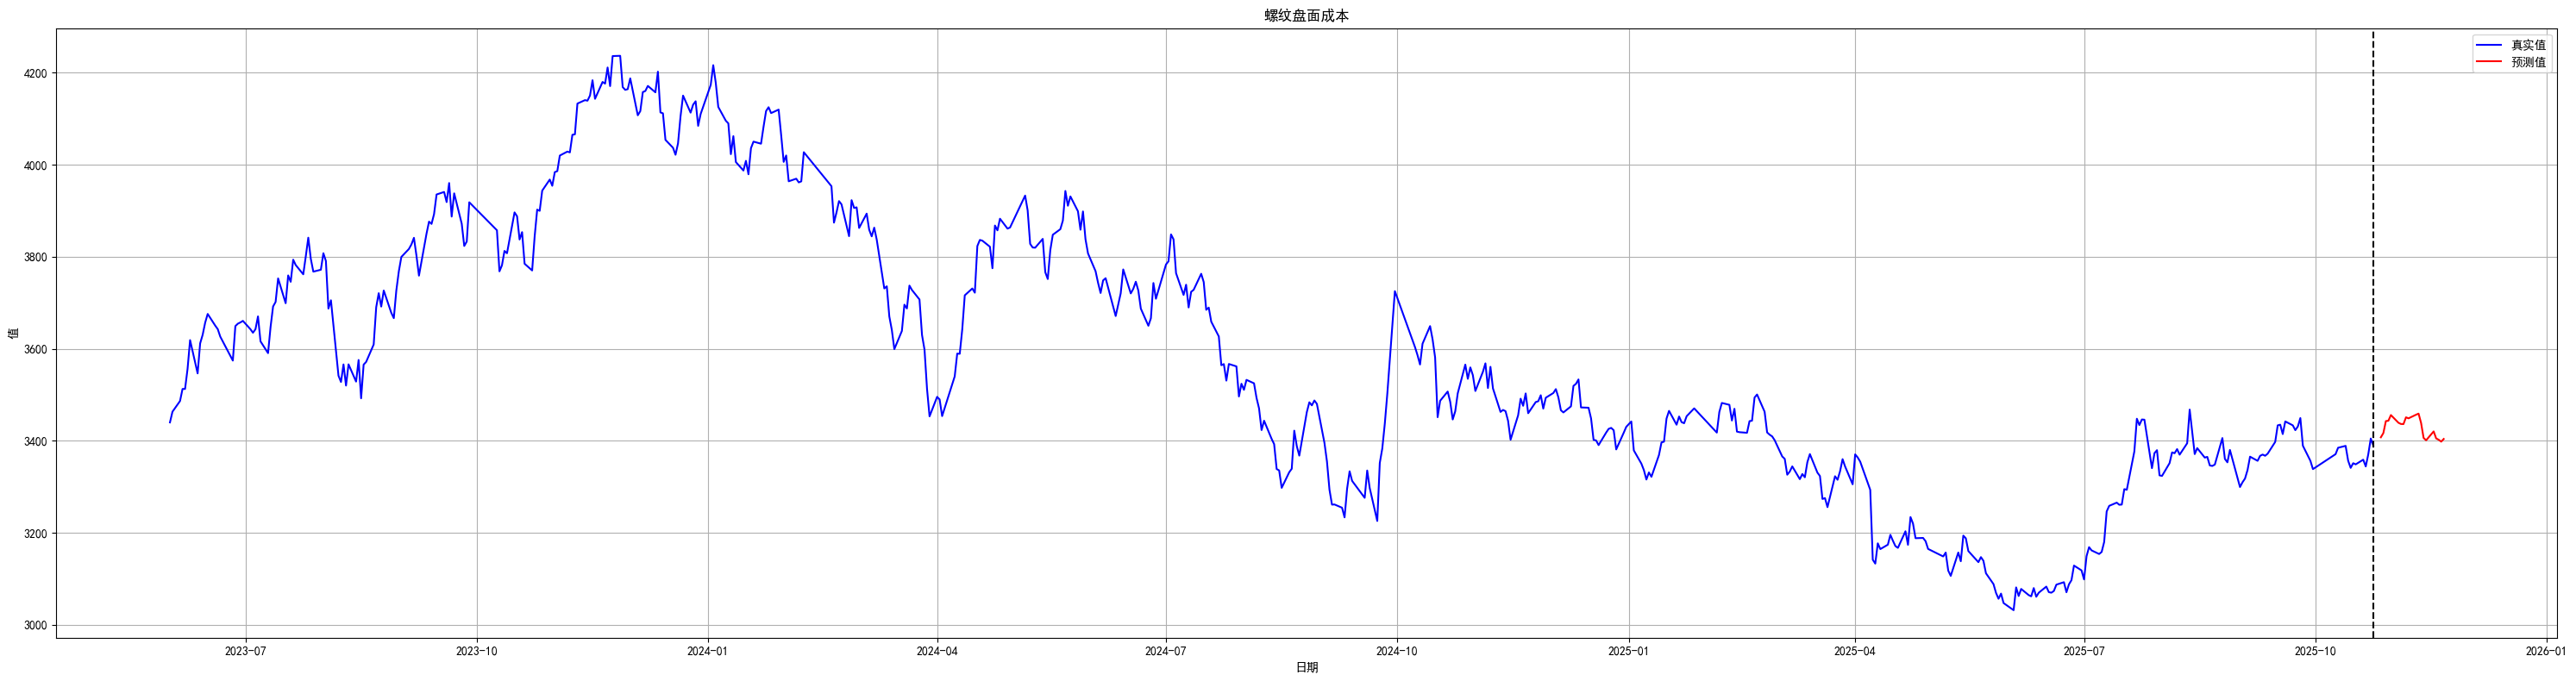

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['螺纹盘面成本'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['螺纹盘面成本_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('螺纹盘面成本')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.螺纹_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "螺纹盘面成本"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.螺纹_数据上传.xlsx"
sheet_name = "详情页"
identifier = "螺纹盘面成本"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
